# Project - Computer Vision #2 Part 2
 
                             by ARYAN JAIN

#### SUMMARY

<b>Context:</b>
    Company X intends to build a face identification model to recognise human faces.
      
<b>Data Description:</b>    
    The dataset comprises of images and its mask where there is a human face
    
<b>Domain:</b>
  Face recognition
    
    
<b>Objectives:</b>
    Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library
 
<b>Key Tasks:</b> Use a pre-trained model trained on Face recognition to recognise similar faces. The intent is to recognise whether two given faces are of the same person or not.

    - Load the dataset and create the metadata.
    - Check some samples of metadata.
    - Load the pre-trained model and weights.
    - Generate Embedding vectors for each face in the dataset.
    - Build distance metrics for identifying the distance between two given images.
    - Use PCA for dimensionality reduction.
    - Build an SVM classifier in order to map each image to its right person.
    - Import the the test image. Display the image. Use the SVM trained model to predict the face.

##### Importing Libraries

In [1]:
# Data Management and Vizualization
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Learning

import cv2
from skimage import io,transform
from tqdm.notebook import tqdm

from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.python.keras.preprocessing.image import image, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf

# Standard ML
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


# Python Imaging Library: to perform operations on images
import PIL
from PIL import Image

# warnings
import warnings
warnings.simplefilter("ignore")

##### training data location

In [2]:
# Define dataset folder & reusable variables

# Source data directory / Training dataset
    # The PINS folder contains one sub-folder for each class which contains images of the respective class
    

data_dir = 'PINS'

In [3]:
# Function to investigate classes

def get_classes(data_dir):
    class_names = {}
    for i,class_name in enumerate(sorted(os.listdir(data_dir))):
        class_names.setdefault(i,class_name)
    return class_names

In [4]:
# Let's look at what classes exist

list_of_classes = get_classes (data_dir)
list_of_classes

{0: 'pins_Aaron Paul',
 1: 'pins_Alvaro Morte',
 2: 'pins_Amanda Crew',
 3: 'pins_Amaury Nolasco',
 4: 'pins_Anna Gunn',
 5: 'pins_Benedict Cumberbatch',
 6: 'pins_Betsy Brandt',
 7: 'pins_Brenton Thwaites',
 8: 'pins_Brit Marling',
 9: 'pins_Bryan Cranston',
 10: 'pins_Caity Lotz',
 11: 'pins_Cameron Monaghan',
 12: 'pins_Chance Perdomo',
 13: 'pins_Chris Evans',
 14: 'pins_Chris Pratt',
 15: 'pins_Cobie Smulders',
 16: 'pins_Danielle Panabaker',
 17: 'pins_Dave Franco',
 18: 'pins_Dominic Purcell',
 19: 'pins_Dwayne Johnson',
 20: 'pins_Emilia Clarke',
 21: 'pins_Emily Bett Rickards',
 22: 'pins_Emma Stone',
 23: 'pins_Gwyneth Paltrow',
 24: 'pins_Henry Cavil',
 25: 'pins_Jason Momoa',
 26: 'pins_Jeremy Renner',
 27: 'pins_Jesse Eisenberg',
 28: 'pins_Jim Parsons',
 29: 'pins_Jon Bernthal',
 30: 'pins_Josh Radnor',
 31: 'pins_Kit Harington',
 32: 'pins_Krysten Ritter',
 33: 'pins_Kumail Nanjiani',
 34: 'pins_Maisie Williams',
 35: 'pins_Mark Ruffalo',
 36: 'pins_Martin Starr',
 37: '

In [5]:
# Just for fun:
    # Let's create dictionaries with names as keys and class as value and vice versa
    
dirs = sorted(os.listdir(data_dir))

#Build the Name to Class ID dictionary
name_to_classid = {d.replace('pins_','').replace('face',''):i for i,d in enumerate(dirs)}
print (name_to_classid)
print ('\n\n')

#Build Class ID to Name dictionary
classid_to_name = dict((y,x) for x,y in name_to_classid.items())
print (classid_to_name)

print(f'\nNumber of classes : {str(len(name_to_classid))}')

{'Aaron Paul': 0, 'Alvaro Morte': 1, 'Amanda Crew': 2, 'Amaury Nolasco': 3, 'Anna Gunn': 4, 'Benedict Cumberbatch': 5, 'Betsy Brandt': 6, 'Brenton Thwaites': 7, 'Brit Marling': 8, 'Bryan Cranston': 9, 'Caity Lotz': 10, 'Cameron Monaghan': 11, 'Chance Perdomo': 12, 'Chris Evans': 13, 'Chris Pratt': 14, 'Cobie Smulders': 15, 'Danielle Panabaker': 16, 'Dave Franco': 17, 'Dominic Purcell': 18, 'Dwayne Johnson': 19, 'Emilia Clarke': 20, 'Emily Bett Rickards': 21, 'Emma Stone': 22, 'Gwyneth Paltrow': 23, 'Henry Cavil': 24, 'Jason Momoa': 25, 'Jeremy Renner': 26, 'Jesse Eisenberg': 27, 'Jim Parsons': 28, 'Jon Bernthal': 29, 'Josh Radnor': 30, 'Kit Harington': 31, 'Krysten Ritter': 32, 'Kumail Nanjiani': 33, 'Maisie Williams': 34, 'Mark Ruffalo': 35, 'Martin Starr': 36, 'Melissa benoit': 37, 'Mike Colter': 38, 'Morena Baccarin': 39, 'Morgan Freeman': 40, 'Natalie Portman ': 41, 'Neil Patrick Harris': 42, 'Paul Rudd': 43, 'Pedro Alonso': 44, 'Peter Dinklage': 45, 'RJ Mitte': 46, 'Rami Melek': 4

In [6]:
# Based on above, the dataset contains 100 classes (well known people)

In [7]:
# Creating a dataframe to collect Metadata: file_nm, class_nm, class_id 

# What was the error Not a directory: 'PINS/.DS_Store. I had to delete this file manually
metadata = []
for directory in os.listdir(data_dir):
    class_name = directory.replace('pins_','').replace('face','')
    class_id   = name_to_classid[class_name]
    
    for file in os.listdir(os.path.join(data_dir, directory)):
        file_name = os.path.join(os.path.join(data_dir, directory), file)
        metadata.append([file_name, class_name, class_id])
        
#data = pd.DataFrame(metadata, columns=['File', 'Celeb-Name','ClassID'])
df = pd.DataFrame(metadata, columns=['file_nm', 'class_nm','class_id'])

df.head()

,file_nm,class_nm,class_id
0,PINS/pins_mark zuckerberg/mark zuckerberg1.jpg,mark zuckerberg,88
1,PINS/pins_mark zuckerberg/mark zuckerberg50.jpg,mark zuckerberg,88
2,PINS/pins_mark zuckerberg/mark zuckerberg44.jpg,mark zuckerberg,88
3,PINS/pins_mark zuckerberg/mark zuckerberg45.jpg,mark zuckerberg,88
4,PINS/pins_mark zuckerberg/mark zuckerberg51.jpg,mark zuckerberg,88


In [8]:
# Let's print number of images and classes

print ('No of Images = ', df.shape[0])
print ('No of Classes = ', len(list_of_classes))

No of Images =  10770
No of Classes =  100


In [9]:
# Let's check how many pictures of each person we have

pd.set_option("max_rows", None)      # display all rows
df.pivot_table(index=['class_id', 'class_nm'], values='file_nm',aggfunc=len)      # pivot table

,,file_nm
class_id,class_nm,
0,Aaron Paul,86
1,Alvaro Morte,91
2,Amanda Crew,118
3,Amaury Nolasco,113
4,Anna Gunn,66
5,Benedict Cumberbatch,81
6,Betsy Brandt,68
7,Brenton Thwaites,130
8,Brit Marling,122


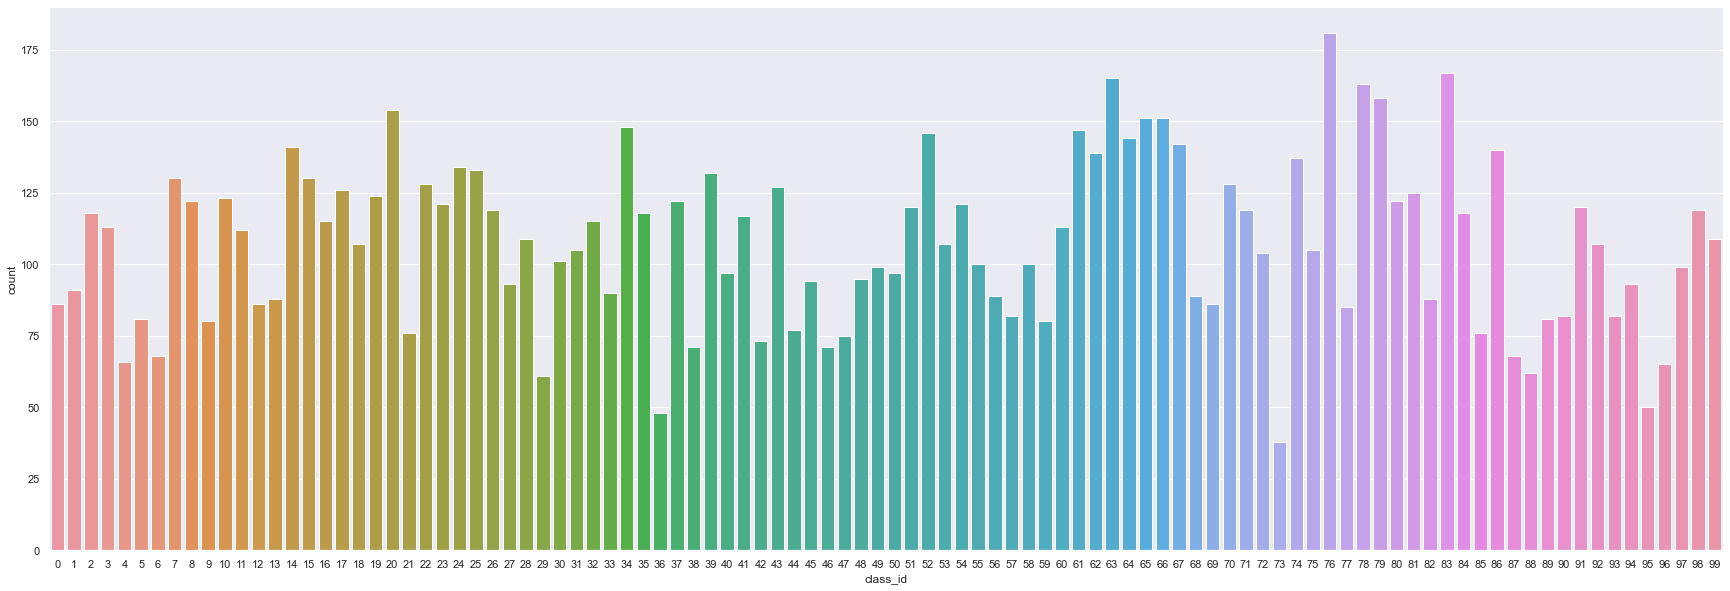

In [10]:
# Let's visualize the class distribution using countplot

sns.set(rc={'figure.figsize':(30,10)})
sns.countplot(df['class_id']) ;

In [13]:
# Just for fun & learning, using another method to display random images

# Function to display 5 images of each class 

def show_sample_images(class_idx):
    i = 0 
    plt.figure()
    name = df[df['class_id'] == class_idx]['file_nm'].values[-1]
    celeb_name = name.split("/")[1].split("_")[1]
    print(f"Images of {celeb_name.title()}")
    
    for filepath in df[df['class_id'] == class_idx]['file_nm'].values[:5]:
        
        i=i+1
        img=io.imread(filepath)
        plt.subplot(1,5,i)
        plt.imshow(img)


Images of Caity Lotz
Images of Sundar Pichai
Images of Gal Gadot Face
Images of Jeff Bezos
Images of Zendaya


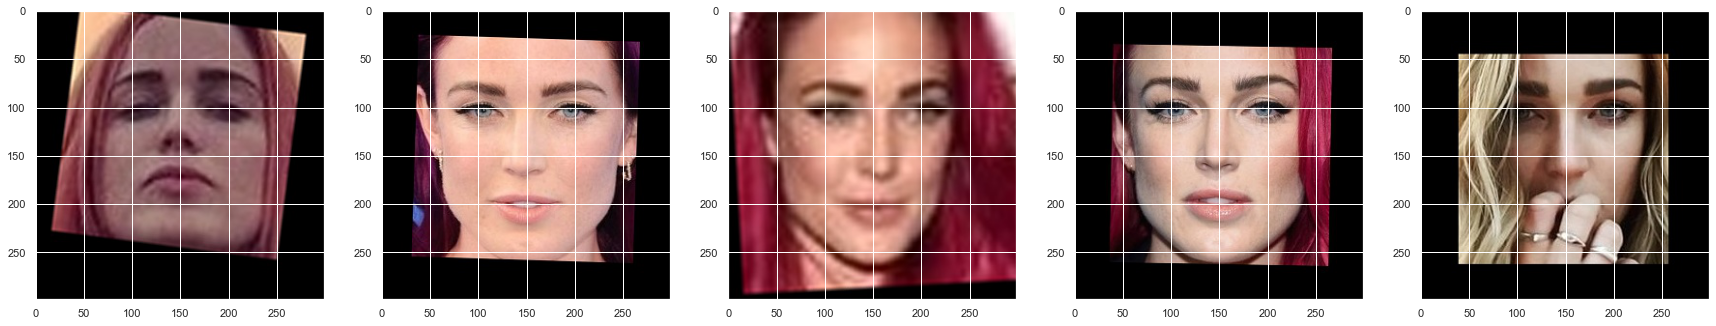

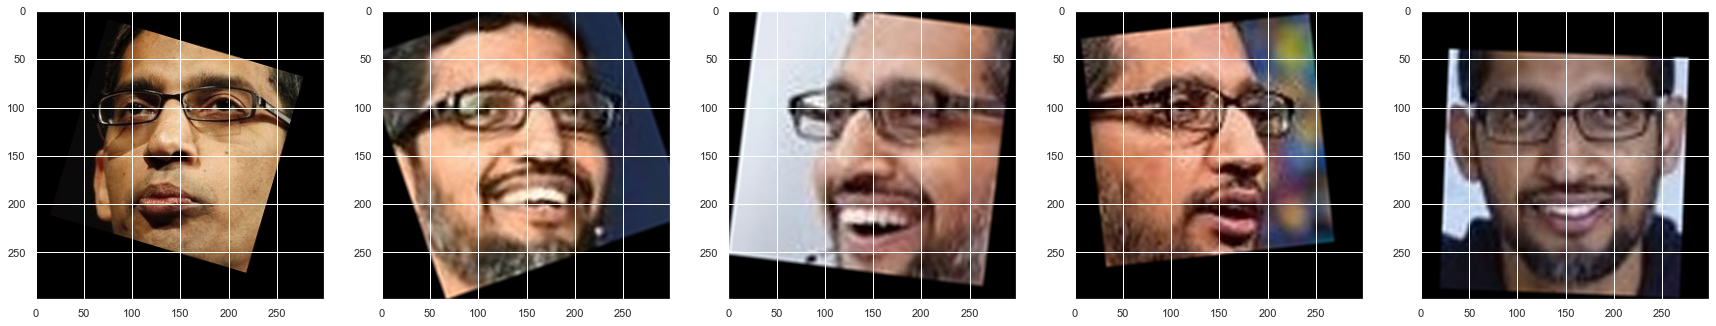

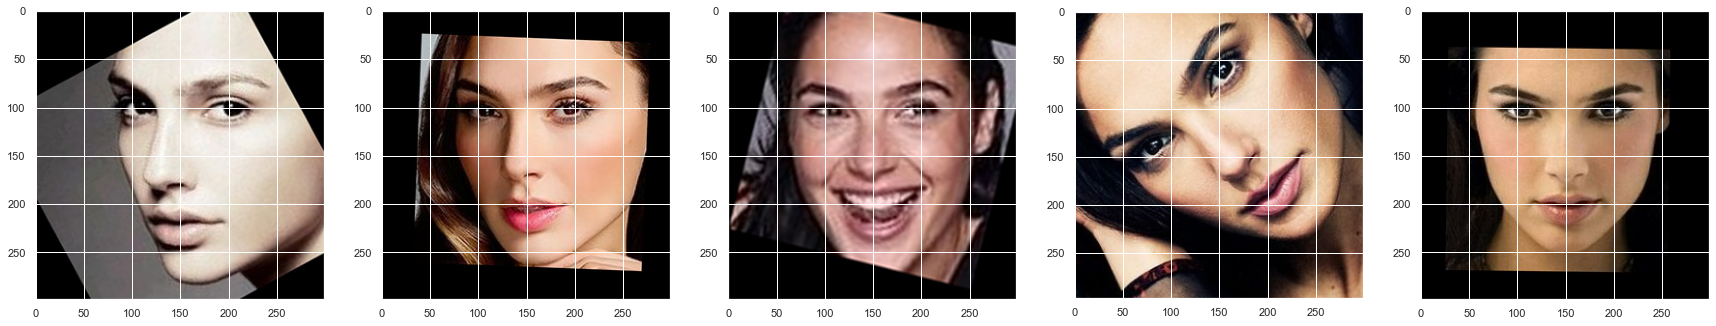

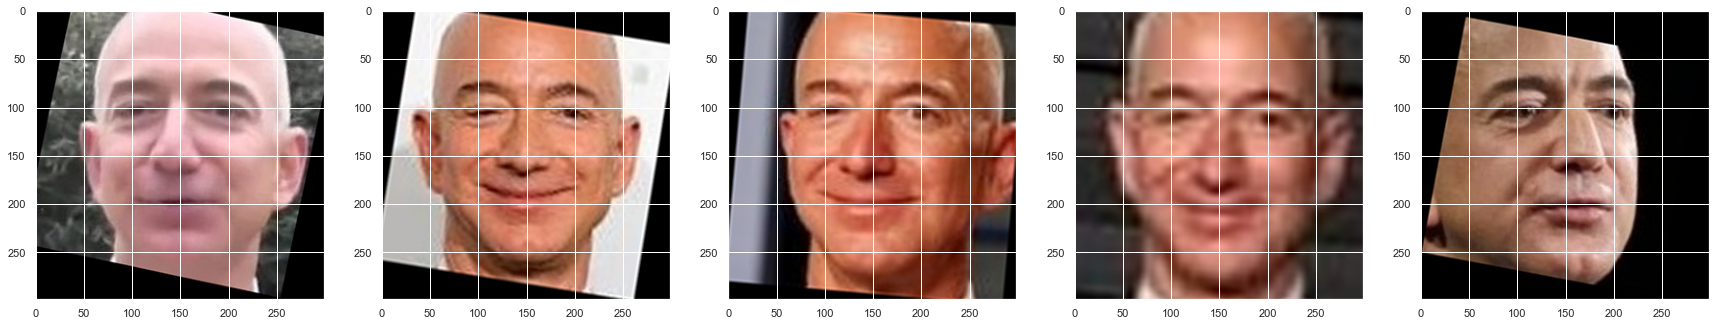

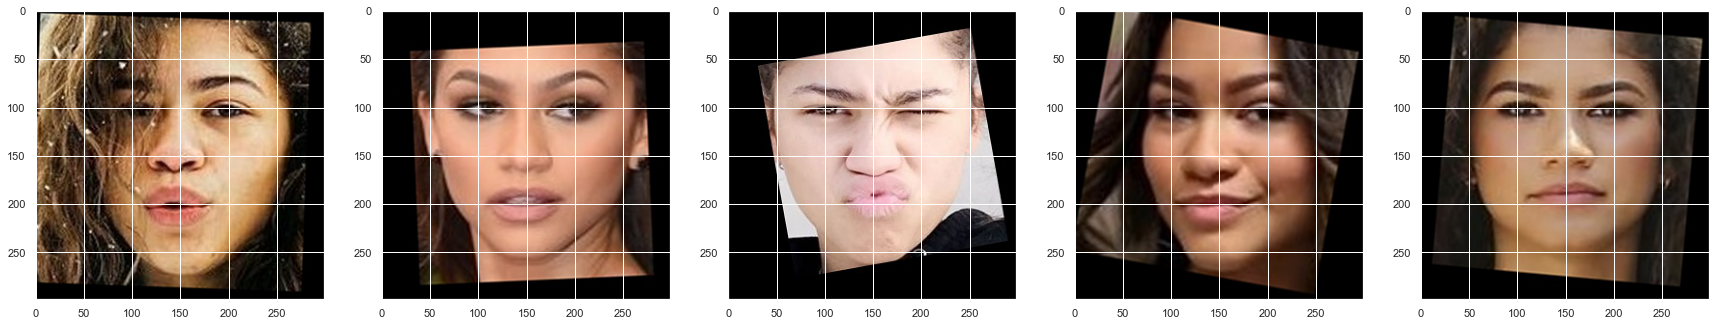

In [16]:
# Choose 5 random classes, call function to display 5 random images of each class

classes = [10, 56, 79, 82, 99]

for id in classes:
    show_sample_images(id)

In [ ]:
# Deep Learning

### Strategy

- The intent is to use pre-trained VGG model, weights file vgg_face_weights.h5
- I will build the VGG model, load provided weight file

Below is the VGG Face model (reference source >>> internet )

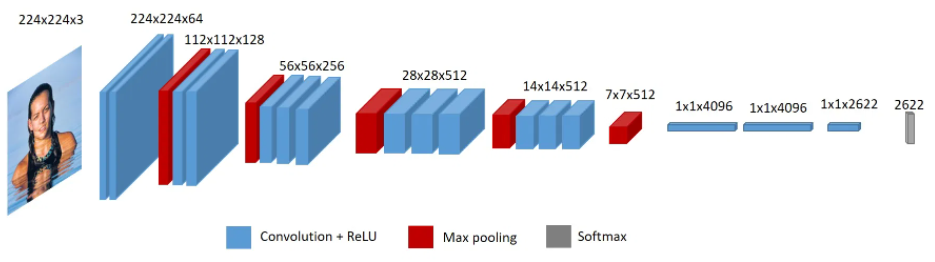


In [ ]:
# VGG Model

# Loading the pre-trained model and weights
# The problem statement includes the weights file vgg_face_weights.h5

# Next step are to build the VGG model, and load the weights from the given weights file

In [17]:
# Build the VGG Model

vgg_model = Sequential()
vgg_model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
vgg_model.add(Convolution2D(64, (3, 3), activation = 'relu'))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(64, (3, 3), activation = 'relu'))

vgg_model.add(MaxPooling2D((2, 2), strides = (2, 2)))    
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(128, (3, 3), activation = 'relu'))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(128, (3, 3), activation = 'relu'))

vgg_model.add(MaxPooling2D((2, 2), strides = (2, 2)))    
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(256, (3, 3), activation = 'relu'))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(256, (3, 3), activation = 'relu'))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(256, (3, 3), activation = 'relu'))

vgg_model.add(MaxPooling2D((2, 2), strides = (2, 2)))    
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(512, (3, 3), activation = 'relu'))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(512, (3, 3), activation = 'relu'))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(512, (3, 3), activation = 'relu'))

vgg_model.add(MaxPooling2D((2, 2), strides =(2, 2)))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(512, (3, 3), activation = 'relu'))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(512, (3, 3), activation = 'relu'))
vgg_model.add(ZeroPadding2D((1, 1)))
vgg_model.add(Convolution2D(512, (3, 3), activation = 'relu'))

vgg_model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
vgg_model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Convolution2D(2622, (1, 1)))

vgg_model.add(Flatten())
vgg_model.add(Activation('softmax'))

In [18]:
# Load provided weight file & display summary

vgg_model.load_weights('Part 3 - vgg_face_weights.h5')
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [ ]:
# What we have done & next steps:

   # We have already loaded the pre-trained weights for the VGG-16 network
   # No need train it further 
   # Will create embedding vectors for facial verification before Flatten layer
   # Use the embedding vectors (face descriptors) to calculate the distance between images

In [19]:
# Get the face descriptor

# Creating a model that takes the input, but then takes output of Flatten layer, rather than softmax
face_descriptor = Model(inputs = vgg_model.layers[0].input, outputs = vgg_model.layers[-2].output)

In [ ]:
# Using face_descriptor.predict, I can get embedding vectors for each image

In [ ]:
# Generate Embedding vectors for each face in the dataset

In [20]:
def read_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels in BGR order. So we need to reverse them
    return img[...,::-1]


In [21]:
# Generate Embedding Vector for first image, validate the the shape

img_path = df['file_nm'][0]
img = read_image(img_path)

# Normalize the input and convert to type float
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print('Shape of image            : ', img.shape)

# Obtain the embedding vector for the above image using face_descriptor model and print the shape
embedding_vector = face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print('Shape of Embedding Vector : ', embedding_vector.shape)

Shape of image            :  (224, 224, 3)
Shape of Embedding Vector :  (2622,)


In [ ]:
# The length of the Embedding Vector is 2622.

# Next Step: generate the Embedding Vector for each image in the dataset

    # Note: the number of embeddings should match number of images in the dataset

In [22]:
embeddings = []

for index, filename in tqdm(enumerate(df.iloc[:, 0])):
    img = read_image(filename)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224, 224))
    embeddings.append(face_descriptor.predict(np.expand_dims(img, axis = 0))[0])
    

print ('Total number of embeddings : ', len(embeddings))


Total number of embeddings :  10770


In [23]:
# OBSERVATION: As expected, total number of embeddings match the total number of images in the dataset

In [24]:
# NEXT STEPS:
    # Write a function to calculate the distance between 2 images
    # Display the distance

##### reference from internet:

$ d(p,q) = \sqrt{\sum \limits_{i=1}^{n} (q_{i} - p_{i}) ^2}  $ 

p,q	=	two points in Euclidean n-space <br/>
$q_{i}, p_{i} $	=	Euclidean vectors, starting from the origin of the space (initial point) <br/>
n	=	n-space

In [25]:
# function that measure the Euclidean Distance between two points

def euc_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))
    
# Display the distance between given pair of images

def check_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {euc_dist(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    img1 = df['file_nm'].iloc[idx1]
    print ('Image 1 : ', img1)
    plt.imshow(read_image(img1))
    
    plt.subplot(122)
    img2 = df['file_nm'].iloc[idx2]
    print ('Image 2 : ', img2, '\n')
    plt.imshow(read_image(img2))

Image 1 :  PINS/pins_mark zuckerberg/mark zuckerberg0.jpg
Image 2 :  PINS/pins_mark zuckerberg/mark zuckerberg0.jpg 

Image 1 :  PINS/pins_mark zuckerberg/mark zuckerberg0.jpg
Image 2 :  PINS/pins_mark zuckerberg/mark zuckerberg53.jpg 

Image 1 :  PINS/pins_mark zuckerberg/mark zuckerberg0.jpg
Image 2 :  PINS/pins_barbara palvin face/barbara palvin face5.jpg 

Image 1 :  PINS/pins_mark zuckerberg/mark zuckerberg0.jpg
Image 2 :  PINS/pins_Jason Momoa/Jason Momoa76.jpg 



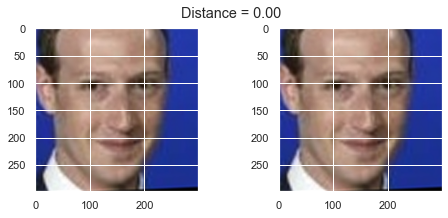

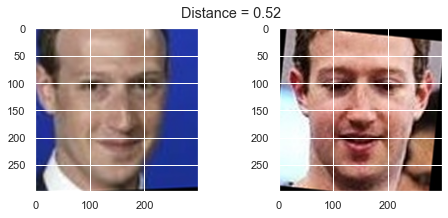

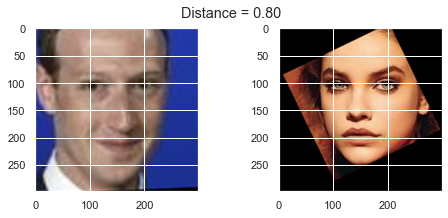

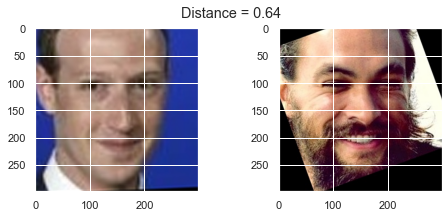

In [26]:
# Let's pick one anchor image and measure distance from 5 random images

check_pair(5, 5)
check_pair(5, 8)
check_pair(5, 300)
check_pair(5, 500)

In [27]:
# OBSERVATIONS:
    # 1st pair: exact same image, the distance = 0 
    # 2nd pair: same person but different position, angle, etc. As a result, the distance increased 0.52
    # 3rd pair: different people of different genders so the distance increased significantly 0.80
    # 4th pair: different people of the same gender so the distance dropped slightly 0.64

##### Getting ready for model building, training & validating
    Split the dataset into training and validation

In [28]:
# setting values for variables
random_s = 7
test_s = 0.3

In [29]:
# The embeddings list has the embeddings of each of the 10770 images
# We get the corresponding label from the classID column of data dataframe

y = df['class_id']
print ('Number of embeddings : ', len(embeddings))
print ('Number of Labels     : ', len(y))

# Split the data into Train and Test dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(embeddings), y, test_size=test_s, random_state=random_s)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

Number of embeddings :  10770
Number of Labels     :  10770


((7539, 2622), (7539,), (3231, 2622), (3231,))

In [30]:
# Let's standarize the features, we could skip this step if we applied BatchNorm in the network
sc = StandardScaler()
Xsc_train = sc.fit_transform(X_train)
Xsc_test  = sc.transform(X_test)

##### Problem statement requires to use PCA for dimensionality reduction

In [31]:
# PCA for dimention reduction

# Step 1 - Create covariance matrix

cov_mat = np.cov(Xsc_train.T)

# Step 2- Get eigen values and eigen vector

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-2.36873712e-02 -2.07472871e-02 -1.80319214e-04 ... -1.90094287e-02
  -4.05639181e-03  4.15639492e-04]
 [ 8.94490000e-03 -5.85544830e-05  1.92279050e-03 ... -9.41898269e-03
   1.31071731e-02  3.51803420e-02]
 [-3.28646674e-03 -8.51692683e-03  9.72900806e-03 ...  1.60232482e-02
  -2.36167037e-03 -5.40416113e-03]
 ...
 [-7.77369216e-03  2.36262104e-02 -1.08441120e-02 ...  8.24551477e-03
  -2.81712565e-03  3.63036930e-02]
 [ 2.18229537e-02  4.87502985e-03  3.35335432e-03 ... -2.15401891e-02
   8.02249909e-03 -9.97934792e-03]
 [ 3.87195261e-02 -1.08608302e-02  1.82938404e-02 ...  2.91680952e-02
  -2.15596994e-02 -2.57737612e-02]]

 Eigen Values 
%s [3.58336835e+02 1.41260544e+02 1.03392577e+02 ... 1.30326771e-03
 1.30686197e-03 1.30589496e-03]


In [32]:
# Display cumulative variance explained
tot_eig_val = sum(eig_vals)
var_exp = [(i /tot_eig_val) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained : ', cum_var_exp)

Cumulative Variance Explained :  [ 13.66473318  19.05152975  22.99427814 ...  99.99999985  99.99999999
 100.        ]


In [33]:
# We want the components that explain 95% of the variance, so let's set a threshold and see how many components explain it
thres = 95
res   = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres} % : {str(index)}')

Index of element just greater than 95 % : 342


In [34]:
# the first 345 elements explain 95% variance and we will use this as our threshold

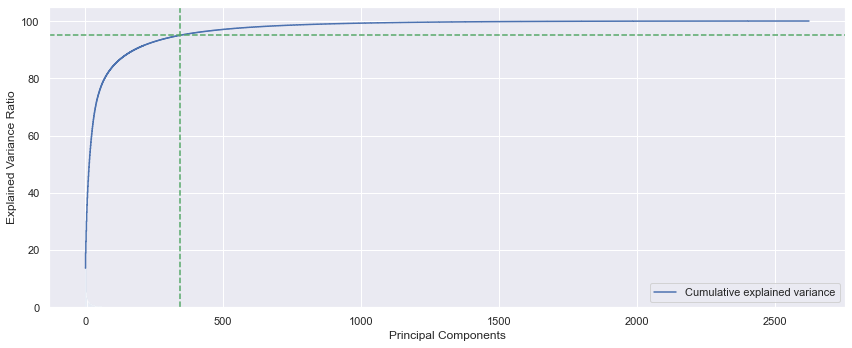

In [49]:
# Let's visualize number of components with variance explained to confirm this
plt.figure(figsize = (12 , 5))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'g', linestyle = '--')
plt.axvline(x = index, color = 'g', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()


# # Alternate simpler method
# plt.plot(cum_var_exp)

In [36]:
# Reducing the dimensions
# we are generating only 8 PCA dimensions (dimensionality reduction from 18 to 8)

## We can manually code in 345 elements, or just input 0.95 and it will automatically take how many components
## in order to explain 95% of the variance

# pca = PCA(n_components=345)
pca = PCA(n_components = 0.95, random_state = random_s, svd_solver = 'full', whiten = True)
pca.fit(Xsc_train)
X_train_pca = pca.transform(Xsc_train)
X_test_pca = pca.transform(Xsc_test)
display(X_train_pca.shape, X_test_pca.shape)


# NOTE - we are generating only 8 PCA dimensions (dimensionality reduction from 18 to 8)



(7539, 343)

(3231, 343)

##### SVM to predict

In [37]:
# NEXT STEP
    # build SVM classifier to predict Class Id

In [38]:
# We can hypertune with GridSearchCV, but I will use the parameters that seem to perform the great in most cases 

In [39]:
svc_model = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced')
svc_model.fit(X_train_pca, y_train)

print('Model Accuracy for train set : {0:.3f}'.format(svc_model.score(X_train_pca, y_train)))

Model Accuracy for train set : 0.994


In [40]:
# Predict
y_pred = svc_model.predict(X_test_pca)

print('Model Accuracy for test set : {0:.3f}'.format(accuracy_score(y_test, y_pred).round(3)))

Model Accuracy for test set : 0.962


In [41]:
# MODEL PERFORMACE

    # The SVM classifier gives an accuracy of 96.3% on test data. This is pretty good.

In [42]:
# Let's print the Classification Report

print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, 
                                                                 target_names = [y for x,y in classid_to_name.items()])))

Classification Report: 
                      precision    recall  f1-score   support

          Aaron Paul       1.00      0.92      0.96        24
        Alvaro Morte       0.87      1.00      0.93        27
         Amanda Crew       0.97      0.97      0.97        29
      Amaury Nolasco       1.00      1.00      1.00        31
           Anna Gunn       1.00      1.00      1.00        24
Benedict Cumberbatch       1.00      0.91      0.95        23
        Betsy Brandt       1.00      1.00      1.00        20
    Brenton Thwaites       0.95      0.92      0.94        39
        Brit Marling       1.00      0.94      0.97        35
      Bryan Cranston       0.92      1.00      0.96        22
          Caity Lotz       0.94      0.97      0.95        30
    Cameron Monaghan       0.95      1.00      0.97        39
      Chance Perdomo       1.00      1.00      1.00        31
         Chris Evans       0.92      0.89      0.91        27
         Chris Pratt       1.00      0.98    

#### 8.1 Predict on test images

In [43]:
def predict_name(file_name):
    # Load the input image 
    img = read_image(file_name)

    # Normalizing pixel values and resize image
    img = (img/255.).astype(np.float32)
    img = cv2.resize(img, (224, 224))

    # Generate the embedding vector for the image
    img_embedding = face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
  
    # Apply standard scaler on the vector and reshape
    img_embedding_scaled = sc.transform(img_embedding.reshape(1, -1))

    # Apply PCA and predict using SVM model
    img_pred  = svc_model.predict(pca.transform(img_embedding_scaled))
    name_pred = classid_to_name[img_pred[0]]

    return img_pred[0], name_pred


In [46]:
# Images to predict

# Per problem statement, following image files are provided to predict.

img1 = 'Part 2 - Test Image - Dwayne Johnson4.jpg'
img2 = 'Part 2- Test Image - Benedict Cumberbatch9.jpg'

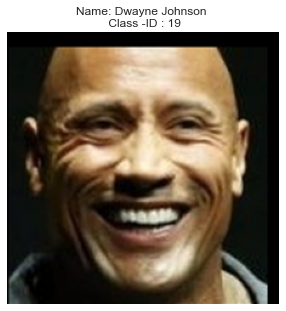

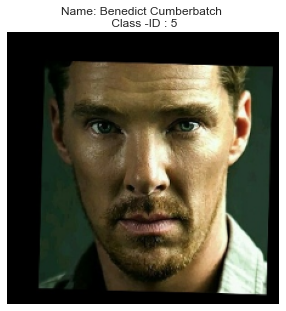

In [47]:
# pred_images = ['P02-Predict-image-01.jpg', 'P02-Predict-image-02.jpg']
pred_images = [img1, img2]

for image in pred_images:
    disp_img = cv2.resize(read_image(image), (224, 224))
    img_class, class_nm = predict_name(image)
    fig = plt.figure(figsize = (15, 5))
    plt.axis('off')
    plt.imshow(disp_img)
    plt.title(f"Name: {class_nm} \n Class -ID : {img_class}")
    plt.show()

In [48]:
# PREDICTION OUTCOME

    # Correctly predicted both the test images

#### END OF PROJECT PART 2